In [1]:
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
import itk
import os

# inspect source code
import inspect

In [4]:
def load_imagen_to_itk(path_):


    # Read the MNC file using nibabel
    mnc_img = nib.load(path_)

    # Get the image data as a numpy array
    data = mnc_img.get_fdata()

    # Convert the numpy array to an ITK object
    itk_img = itk.image_view_from_array(data)

    # Print the image information
    #print(itk_img)

    # Plot a slice of the image
    plt.imshow(itk.array_view_from_image(itk_img)[:,:,25], cmap='gray')
    plt.show()

    return itk_img



In [15]:
def plot_image(image_, k_level= 25):
    array = itk.array_view_from_image(image_)[:,:,k_level]

    # Plot the image using Matplotlib
    plt.imshow(array, cmap="gray")
    plt.show()
    return None

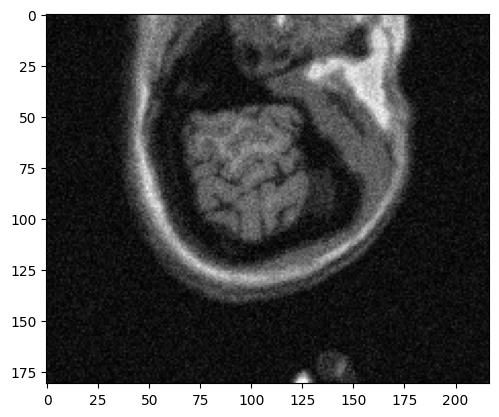

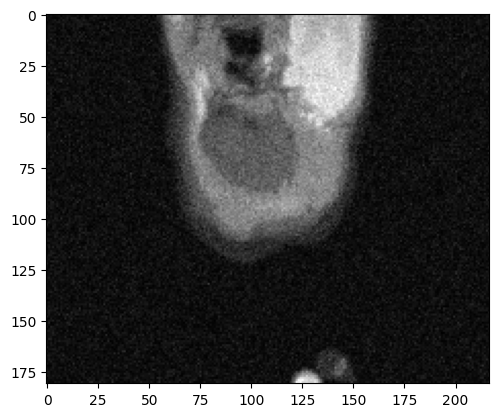

In [23]:
path_ = 'data/t1_icbm_normal_1mm_pn9_rf20.mnc.gz'
reader = load_imagen_to_itk(path_)
plot_image(reader, k_level=12)

## Median Filter

In [11]:
def median_filter(data, filter_size):
    #data = itk.GetArrayViewFromImage(data)
    #data = itk.GetArrayViewFromImage(data)#[:,:,25]
    temp = list()
    # border of the region to calculate median filter
    #max = filter_size // 2
    data_final = np.zeros((len(data),len(data[0])))
    # Scroll rows
    for i in range(len(data)):
        # scroll columns
        for j in range(len(data[0])):
            # scroll acording to size circle (in this case it's a rectangule neighborhuts)
            for r in range(-1*filter_size,  filter_size+1):
                # validate if the point is not between the imagen coordinates
                if (i + r < 0) or (i+r ) > (len(data)-1):
                    pass
                #validate if the point in y coordinate
                elif (j + r  < 0) or (j+r ) > (len(data[0])-1): 
                    pass  
                else:
                    # get all elements in the border and we are including the center
                    for k in range(-1*filter_size,  filter_size+1):
                        # validate if the point is not between the imagen coordinates
                        if (i + k < 0) or (i+k ) > (len(data)-1):
                            pass
                        #validate if the point in y coordinate
                        elif (j + k  < 0) or (j+k ) > (len(data[0])-1): 
                            pass  
                        elif (r==0) and (j==0):
                            pass
                        else:
                            temp.append(data[i + r ][j + k ])
            
            temp.sort()
            #print(temp)
            if len(temp) > 0:
                data_final[i][j] = temp[len(temp) // 2]

            
            #print('--')
            temp = list()
    return data_final
    #return itk.image_view_from_array(data_final)

In [8]:
data_array = itk.GetArrayViewFromImage(reader)
data_final = np.zeros((len(data_array), len(data_array[0]), len(data_array[0, 0])))
print(data_array.shape)
print(data_final.shape)

for k in range(len(data_array[0,0])):
    data_final[:,:,k] = median_filter(data_array[:,:,k], filter_size=1)

median_filter_image = itk.GetImageFromArray(data_final)


(181, 217, 181)
(181, 217, 181)


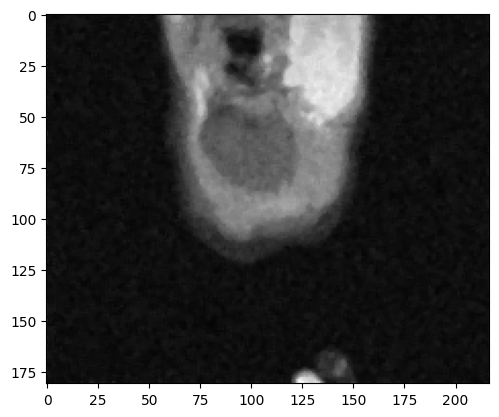

In [24]:
plot_image(median_filter_image,k_level=12)

### Adaptive Filter median 

In [44]:
def get_sxy( data, filter_size, i , j):
    s_xy = list()
   
    # scroll acording to size circle (in this case it's a rectangule neighborhuts)
    for r in range(-1*filter_size,  filter_size+1):
        # validate if the point is not between the imagen coordinates
        if (i + r < 0) or (i+r ) > (len(data)-1):
            pass
        #validate if the point in y coordinate
        elif (j + r  < 0) or (j+r ) > (len(data[0])-1): 
            pass  
        else:
            # get all elements in the border and we are including the center
            for k in range(-1*filter_size,  filter_size+1):
                # validate if the point is not between the imagen coordinates
                if (i + k < 0) or (i+k ) > (len(data)-1):
                    pass
                #validate if the point in y coordinate
                elif (j + k  < 0) or (j+k ) > (len(data[0])-1): 
                    pass  
                else:
                    s_xy.append(data[i + r ][j + k ])

    return s_xy

def conditions(data, filter_size, i , j):
    s_xy = get_sxy( data=data, filter_size=filter_size, i=i , j=j)

    

    # Adaptive conditions
    
    l11  = np.average(s_xy) - np.min(s_xy)
    l12  = np.average(s_xy) - np.max(s_xy)

    if (l11 >0) and (l12 < 0):
        #level 2
        
        gray_level = data[i,j]   
        l21  =gray_level- np.min(s_xy)
        l22  =gray_level- np.max(s_xy)  
        if (l21 >0) and (l22 < 0):
            result = gray_level
        else:
            result = round(np.average(s_xy),2)


    else: 
        if (filter_size>= len(data)) or (filter_size>= len(data[0])):
            # add condition vecause repeat level 1 is redundant
            result = 0
        else:
            result = conditions(data=data, filter_size=filter_size+1, i=i , j=j)
        
    return result


def median_adaptive_filter(data_, filter_size):
    data = data_
    #data = itk.GetArrayViewFromImage(data_)
    # border of the region to calculate median filter
    #max = filter_size // 2
    data_final = np.zeros((len(data),len(data[0])))

     # Scroll rows
    for i in range(len(data)):
        # scroll columns
        for j in range(len(data[0])):
            
            data_final[i,j] = conditions(data=data, filter_size=filter_size, i=i , j=j)
    
    #return data_final
    return itk.image_view_from_array(data_final)

In [45]:
data_array = itk.GetArrayViewFromImage(reader)
data_final = np.zeros((len(data_array), len(data_array[0]), len(data_array[0, 0])))
print(data_array.shape)
print(data_final.shape)

for k in range(len(data_array[0,0])):
    data_final[:,:,k] = median_adaptive_filter(data_array[:,:,k], filter_size=1)

median_adaptive_filter_imgae = itk.GetImageFromArray(data_final)


(181, 217, 181)
(181, 217, 181)


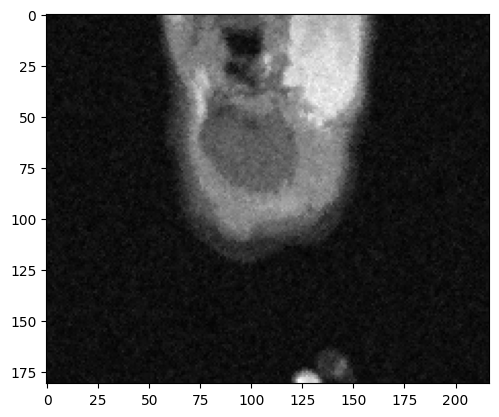

In [46]:
plot_image(median_adaptive_filter_imgae,k_level=12)

#### version funcional

In [3]:
def plot_image(image_):
    array = itk.array_view_from_image(image_)

    # Plot the image using Matplotlib
    plt.imshow(array, cmap="gray")
    plt.show()
    return None

In [4]:
# cast mnc image to niif
def cast_mnc_to_nii(path_):

    minc = nib.load(path_)
    basename = minc.get_filename().split(os.extsep, 1)[0]

    affine = np.array([[0, 0, 1, 0],
                    [0, 1, 0, 0],
                    [1, 0, 0, 0],
                    [0, 0, 0, 1]])

    out = nib.Nifti1Image(minc.get_fdata(), affine=affine)
    nib.save(out, basename + '.nii.gz')

In [5]:
path_ = 'data/t1_icbm_normal_1mm_pn9_rf20.mnc.gz'
cast_mnc_to_nii(path_)

In [6]:
# define image dimensions
PixelType = itk.UC
Dimension = 2

ImageType = itk.Image[PixelType, Dimension]

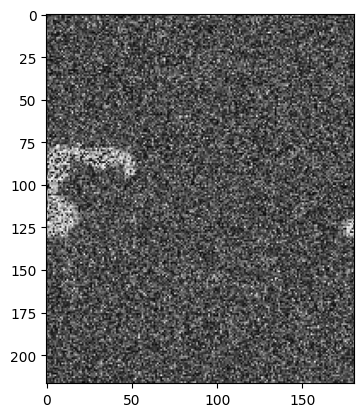

In [7]:
path_ = 'data/t1_icbm_normal_1mm_pn9_rf20.nii'

ReaderType = itk.ImageFileReader[ImageType]
reader = ReaderType.New()
reader.SetFileName( path_ )
reader.Update()
plot_image(reader)

In [110]:
#### Apply median filter

In [8]:
def median_filter(data, filter_size):
    data = itk.GetArrayViewFromImage(data)
    temp = list()
    # border of the region to calculate median filter
    #max = filter_size // 2
    data_final = np.zeros((len(data),len(data[0])))
    # Scroll rows
    for i in range(len(data)):
        # scroll columns
        for j in range(len(data[0])):
            # scroll acording to size circle (in this case it's a rectangule neighborhuts)
            for r in range(-1*filter_size,  filter_size+1):
                # validate if the point is not between the imagen coordinates
                if (i + r < 0) or (i+r ) > (len(data)-1):
                    pass
                #validate if the point in y coordinate
                elif (j + r  < 0) or (j+r ) > (len(data[0])-1): 
                    pass  
                else:
                    # get all elements in the border and we are including the center
                    for k in range(-1*filter_size,  filter_size+1):
                        # validate if the point is not between the imagen coordinates
                        if (i + k < 0) or (i+k ) > (len(data)-1):
                            pass
                        #validate if the point in y coordinate
                        elif (j + k  < 0) or (j+k ) > (len(data[0])-1): 
                            pass  
                        elif (r==0) and (j==0):
                            pass
                        else:
                            temp.append(data[i + r ][j + k ])
            #print(temp)
            data_final[i][j] = round(np.average(temp),2)
            temp = list()
    #return data_final
    return itk.image_view_from_array(data_final)

Mean of empty slice.
invalid value encountered in scalar divide


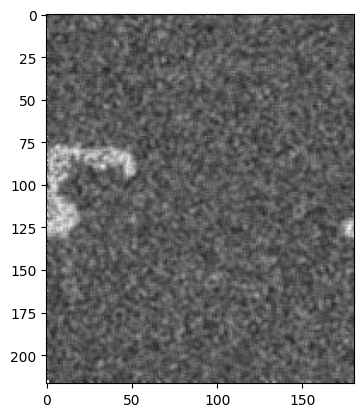

In [9]:
plot_image(median_filter(reader, filter_size=1))

In [10]:
## median adaptive filter 

In [42]:
def get_sxy( data, filter_size, i , j):
    s_xy = list()
   
    # scroll acording to size circle (in this case it's a rectangule neighborhuts)
    for r in range(-1*filter_size,  filter_size+1):
        # validate if the point is not between the imagen coordinates
        if (i + r < 0) or (i+r ) > (len(data)-1):
            pass
        #validate if the point in y coordinate
        elif (j + r  < 0) or (j+r ) > (len(data[0])-1): 
            pass  
        else:
            # get all elements in the border and we are including the center
            for k in range(-1*filter_size,  filter_size+1):
                # validate if the point is not between the imagen coordinates
                if (i + k < 0) or (i+k ) > (len(data)-1):
                    pass
                #validate if the point in y coordinate
                elif (j + k  < 0) or (j+k ) > (len(data[0])-1): 
                    pass  
                else:
                    s_xy.append(data[i + r ][j + k ])

    return s_xy

def conditions(data, filter_size, i , j):
    s_xy = get_sxy( data=data, filter_size=filter_size, i=i , j=j)

    

    # Adaptive conditions
    
    l11  = np.average(s_xy) - np.min(s_xy)
    l12  = np.average(s_xy) - np.max(s_xy)

    if (l11 >0) and (l12 < 0):
        #level 2
        
        gray_level = data[i,j]   # validate that function 
        l21  =gray_level- np.min(s_xy)
        l22  =gray_level- np.max(s_xy)  # teacher's asking
        if (l21 >0) and (l22 < 0):
            result = gray_level
        else:
            result = round(np.average(s_xy),2)


    else: 
        if (filter_size>= len(data)) or (filter_size>= len(data[0])):
            # add condition vecause repeat level 1 is redundant
            result = 0
        else:
            result = conditions(data=data, filter_size=filter_size+1, i=i , j=j)
        
    return result


def median_adaptive_filter(data_, filter_size):
    data = itk.GetArrayViewFromImage(data_)
    # border of the region to calculate median filter
    #max = filter_size // 2
    data_final = np.zeros((len(data),len(data[0])))

     # Scroll rows
    for i in range(len(data)):
        # scroll columns
        for j in range(len(data[0])):
            
            data_final[i,j] = conditions(data=data, filter_size=filter_size, i=i , j=j)
    
    #return data_final
    return itk.image_view_from_array(data_final)

In [43]:
plot_image(median_adaptive_filter(reader, filter_size=1))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## TEST

In [ ]:
def median_filter(data, filter_size):
    temp = []
    indexer = filter_size // 2
    data_final = []
    data_final = np.zeros((len(data),len(data[0])))
    # Scroll rows
    for i in range(len(data)):
        # scroll columns
        for j in range(len(data[0])):
            # scroll acording to size circle (in this case it's a rectangule neighborhuts)
            for z in range(filter_size):
                if i + z - indexer < 0 or i + z - indexer > len(data) - 1:
                    for c in range(filter_size):
                        temp.append(0)
                else:
                    if j + z - indexer < 0 or j + indexer > len(data[0]) - 1:
                        temp.append(0)
                    else:
                        for k in range(filter_size):
                            temp.append(data[i + z - indexer][j + k - indexer])

            temp.sort()
            data_final[i][j] = temp[len(temp) // 2]
            temp = []
    return data_final

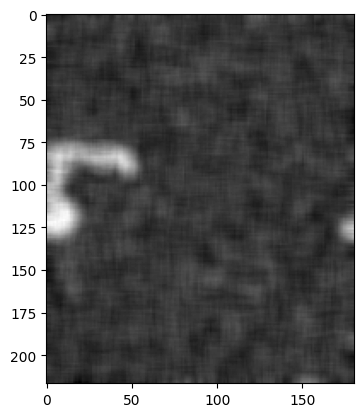

In [37]:

radius = 5

meanFilter = itk.MeanImageFilter[ImageType, ImageType].New()
meanFilter.SetInput(reader.GetOutput())
meanFilter.SetRadius(radius)

plot_image(meanFilter)